# Captcha Prediction Model

In [1]:
import albumentations
import numpy as np
import pandas as pd
import os
import glob
import random
from pprint import pprint
from tqdm import tqdm

# PyTorch Model
import torch
from torch import nn
from torch.nn import functional as F

# Dataset Loading
from PIL import Image
from PIL import ImageFile

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Model Training
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# Configurations for the files
DIR = "../input/captcha-images/"
BATCH_SIZE = 8
IMG_HEIGHT = 75
IMG_WIDTH = 300
EPOCHS = 150
NUM_WORKERS = 4
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


## Image Analysis

In [3]:
paths = []
labels = []
for image in os.listdir(DIR):
    paths.append(os.path.join(DIR, image))
    labels.append(image.split(".")[0])

df = pd.DataFrame({
    "paths": paths,
    "labels": labels
})

df.head()

,paths,labels
0,../input/captcha-images/9PNbWC13Ys.jpg,9PNbWC13Ys
1,../input/captcha-images/8TVve827jK.jpg,8TVve827jK
2,../input/captcha-images/OJ0YWLEie9.jpg,OJ0YWLEie9
3,../input/captcha-images/w3ph8L0ulv.jpg,w3ph8L0ulv
4,../input/captcha-images/9Ia9SnebKw.jpg,9Ia9SnebKw


In [4]:
def show_random_images(df, column_name):
    f = plt.figure(figsize=(10,10))
    i=1
    for i in range(16):
        i += 1
        ax = f.add_subplot(4,4,i)
        sample = random.choice(df[column_name])
        image = mpimg.imread(sample)
        ax.set_title(sample.split("/")[-1])
        plt.imshow(image)

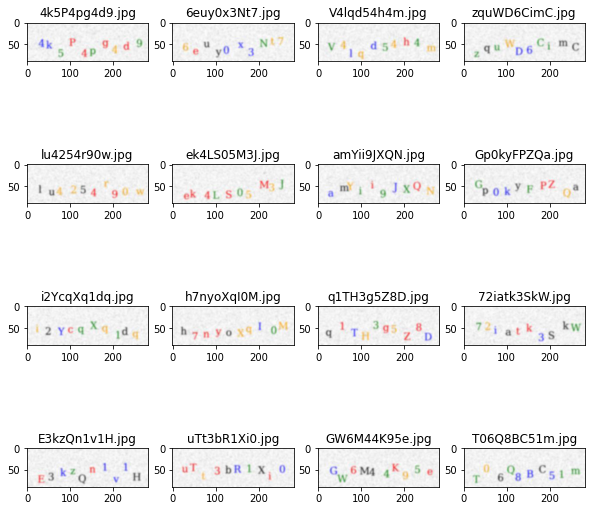

In [5]:
show_random_images(df, "paths")

## Model

In [6]:
def get_loss_function(x, bs, targets):
    log_softmax_values = F.log_softmax(x, 2)

    input_lengths = torch.full(
        size=(bs,), fill_value=log_softmax_values.size(0), dtype=torch.int32
    )

    target_lengths = torch.full(
        size=(bs,), fill_value=targets.size(1), dtype=torch.int32
    )

    return nn.CTCLoss(blank=0)(log_softmax_values, targets, input_lengths, target_lengths)

In [7]:
class MyCaptchaModel(nn.Module):
    def __init__(self, num_chars):
        super(MyCaptchaModel, self).__init__()
        
        # CNN Layer
        self.conv1 = nn.Conv2d(3, 128, kernel_size=(3,3), padding=(1,1))
        self.maxpool1 = nn.MaxPool2d(kernel_size=(2,2))
        
        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3,3), padding=(1,1))
        self.maxpool2 = nn.MaxPool2d(kernel_size=(2,2))
        
        # RNN Layer Preprocess
        self.linear1 = nn.Linear(1152, 64)
        self.drop1 = nn.Dropout(0.2)
        
        # LSTM GRU
        self.gru = nn.GRU(64, 32, bidirectional=True, num_layers=2, dropout=0.25, batch_first=True)
        self.output = nn.Linear(64, num_chars+1)
        
    def forward(self, images, targets=None):  
        bs, channel, height, width = images.size()
        
        x = F.relu(self.conv1(images))
        x = self.maxpool1(x)

        x = F.relu(self.conv2(x))
        x = self.maxpool2(x)

        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)

        x = self.linear1(x)
        x = self.drop1(x)

        x, _ = self.gru(x)
        x = self.output(x)
        x = x.permute(1, 0, 2)

        if targets is not None:
            loss = get_loss_function(x, bs, targets)
            return x, loss
        
        return x, None

In [8]:
def train_function(model, data_loader, optimizer):
    model.train()
    fin_loss = 0
    tk = tqdm(data_loader, total=len(data_loader))
    for data in tk:
        for k, v in data.items():
            data[k] = v.to(DEVICE)
        
        optimizer.zero_grad()
        _, loss = model(**data)
        loss.backward()
        optimizer.step()
        fin_loss += loss.item()

    return fin_loss / len(data_loader)

    
def eval_function(model, data_loader):
    model.eval()
    fin_loss = 0
    fin_preds = []
    with torch.no_grad(): 
        tk = tqdm(data_loader, total=len(data_loader))
        for data in tk:
            for k, v in data.items():
                data[k] = v.to(DEVICE)

            batch_preds, loss = model(**data)
            fin_loss += loss.item()
            fin_preds.append(batch_preds)

    return fin_preds, fin_loss / len(data_loader)

## Parse Images & Encode Labels

In [9]:
def encode_targets():
  # Load images from files
  image_files = glob.glob(os.path.join(DIR, "*.jpg"))
  image_files_png = glob.glob(os.path.join(DIR, "*.png"))
  image_files.extend(image_files_png)
  targets_orig = [x.split("/")[-1].split(".")[0] for x in image_files]
  targets = [[c for c in x] for x in targets_orig]
  targets_flat = [c for clist in targets for c in clist] # squeeze

  # Encode images
  lbl_enc = LabelEncoder()
  lbl_enc.fit(targets_flat)

  targets_enc = [lbl_enc.transform(x) for x in targets]
  targets_enc = np.array(targets_enc) + 1 # transform to np and remove 0 index

  return image_files, targets_enc, targets_orig, lbl_enc

In [10]:
# Train-test split
image_files, targets_enc, targets_orig, lbl_enc = encode_targets()

(train_imgs, test_imgs, train_targets, test_targets, _, test_orig_targets) = train_test_split(
    image_files, targets_enc, targets_orig, test_size=0.1, random_state=0)

## Dataset Classifier Class

In [11]:
ImageFile.LoadTruncatedImages = True

class DatasetClassifier:
    def __init__(self, image_paths, targets, resize=None):
        self.image_paths = image_paths
        self.targets = targets
        self.resize = resize
        self.aug = albumentations.Compose(
            [
             albumentations.Normalize(always_apply=True)
            ]
            )
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):
        image = Image.open(self.image_paths[item]).convert("RGB")
        target = self.targets[item]
        
        if self.resize is not None:
            image = image.resize((self.resize[1], self.resize[0]), resample=Image.Resampling.BILINEAR)
        
        image = np.array(image)
        augmented = self.aug(image=image)
        image = augmented["image"]
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        
        return {
            "images": torch.tensor(image, dtype=torch.float),
            "targets": torch.tensor(target, dtype=torch.long)
        }

In [12]:
# Classify images, load using pytorch's DataLoader
train_dataset = DatasetClassifier(
    image_paths=train_imgs, targets=train_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

test_dataset = DatasetClassifier(
    image_paths=test_imgs, targets=test_targets, resize=(IMG_HEIGHT, IMG_WIDTH)
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=False
)

/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Create Model, Optimizers, Callbacks

In [13]:
# Load the models
model = MyCaptchaModel(num_chars=len(lbl_enc.classes_))
model.to(DEVICE)

# Create optimizer and callbacks
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.8, patience=5, verbose=True
)

In [14]:
def early_stopping(patience, count, prev_loss, current_loss, threshold):
    if abs(prev_loss - current_loss) < threshold and count >= patience:
        return "stop" 
    elif abs(prev_loss - current_loss) < threshold:
        return "count"
    else:
        return False

## Decoding the Predictions

In [15]:
def decode_predictions(preds, encoder):
    preds = preds.permute(1, 0, 2)
    preds = torch.softmax(preds, 2)
    preds = torch.argmax(preds, 2)
    preds = preds.detach().cpu().numpy()
    cap_preds = []
    for j in range(preds.shape[0]):
        temp = []
        for k in preds[j,:]:
            k = k - 1
            if k == -1:
                temp.append("-")
            else:
                temp.append(encoder.inverse_transform([k])[0])
        tp = "".join(temp)
        cap_preds.append(tp)
    return cap_preds

## Running the training model

In [16]:
patience = 6
count = 0
prev_train_loss = 0
threshold = 0.05
loss = []

for epoch in range(EPOCHS):
    train_loss = train_function(model, train_loader, optimizer)
    valid_preds, valid_loss = eval_function(model, test_loader)
    valid_cap_preds = []

    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
        valid_cap_preds.extend(current_preds)
        
    pprint(list(zip(test_orig_targets, valid_cap_preds))[15:20])
    print(f"Epoch: {epoch}, train_loss: {train_loss}, valid_loss: {valid_loss}")
    
    res = early_stopping(patience, count, prev_train_loss, train_loss, threshold)
    
    loss.append(train_loss)
    
    if res == "stop":
        print("Early Stopping Implemented.")
        final_epoch = epoch
        break
    elif res == "count" and train_loss < 0.2:
        count += 1
        print(f"Patience at {patience-count}")
    else:
        prev_train_loss = train_loss

100%|██████████| 125/125 [00:02<00:00, 42.63it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 0, train_loss: 4.6603832562764484, valid_loss: 4.249878211975098


100%|██████████| 125/125 [00:03<00:00, 41.13it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 1, train_loss: 4.240114123450385, valid_loss: 4.251077056884766


100%|██████████| 125/125 [00:02<00:00, 47.20it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 2, train_loss: 4.23869393963284, valid_loss: 4.247766208648682


100%|██████████| 125/125 [00:02<00:00, 47.60it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '---------------------------------------------------------------------------'),
 ('Il40rp4HT2',
  '---------------------------------------------------------------------------')]
Epoch: 3, train_loss: 4.229207306755914, valid_loss: 4.2201494750976565


100%|██████████| 125/125 [00:03<00:00, 37.38it/s]


[('FP8D31PB8O',
  '---------------------------------------------------------------------------'),
 ('y6V9drq2FD',
  '---------------------------------------------------------------------------'),
 ('VIQpVKs9cA',
  '---------------------------------------------------------------------------'),
 ('Vc0XVdk8Rl',
  '-----------------------------------------------4---------------------------'),
 ('Il40rp4HT2',
  '------------------------------------------------4--------------------------')]
Epoch: 4, train_loss: 4.161050529268053, valid_loss: 4.082747110366821


100%|██████████| 125/125 [00:02<00:00, 46.01it/s]


[('FP8D31PB8O',
  '-----E-------1-----0-------H------3-----1-------H----6-------------0---3---'),
 ('y6V9drq2FD',
  '------x------6-------V------9------------0-----1-------5----1------1-------'),
 ('VIQpVKs9cA',
  '--------w---1--------1-----6-------V-----K-------------9-----3-----k-------'),
 ('Vc0XVdk8Rl',
  '-----V-------3--------3-----N-------------1----4--------2--H-------1-------'),
 ('Il40rp4HT2',
  '-------1------3-------4----0------1------H------4----6-------1-------3-----')]
Epoch: 5, train_loss: 3.614440657933553, valid_loss: 2.6311437492370606


100%|██████████| 125/125 [00:02<00:00, 46.48it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------g-----r-----q-------5----F------D-------'),
 ('VIQpVKs9cA',
  '--------x---l--------Q-----6-------V-----K----s--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0--------M------------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------1------j-------4----0------r------p------4----H-------1-------2-----')]
Epoch: 6, train_loss: 1.9182598476409911, valid_loss: 1.0473672590255738


100%|██████████| 125/125 [00:02<00:00, 44.28it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99------q-----r-----g-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------X---VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------J------l-------4----0------r------p------4-----H------1-------2-----')]
Epoch: 7, train_loss: 0.8727539707554711, valid_loss: 0.44679458045959475


100%|██████████| 125/125 [00:02<00:00, 42.66it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99------q-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX---V--------d----k------8----b-------l-------'),
 ('Il40rp4HT2',
  '-------I------j-------4----0------r------p------4-----H------1-------2-----')]
Epoch: 8, train_loss: 0.45616874855094486, valid_loss: 0.2511452234983444


100%|██████████| 125/125 [00:03<00:00, 41.36it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----BB----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX---V--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------J------l-------4----0------r------p------4-----H------T-------2-----')]
Epoch: 9, train_loss: 0.2919348374803861, valid_loss: 0.1544513311982155


100%|██████████| 125/125 [00:02<00:00, 45.40it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0--------X---V--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------J------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 10, train_loss: 0.20446270626783372, valid_loss: 0.10626975125074387


100%|██████████| 125/125 [00:02<00:00, 44.95it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------V-----K----s--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------XX---V--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T-------2-----')]
Epoch: 11, train_loss: 0.14915447552998862, valid_loss: 0.07910622288286685


100%|██████████| 125/125 [00:02<00:00, 42.39it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P-----B----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------XX---V--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4-----H------T-------2-----')]
Epoch: 12, train_loss: 0.11715977979865339, valid_loss: 0.05963730864226818
Patience at 5


100%|██████████| 125/125 [00:02<00:00, 46.46it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q------22----F------D-------'),
 ('VIQpVKs9cA',
  '-------VV---I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------J------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 13, train_loss: 0.0977363352527221, valid_loss: 0.05482275895401836


100%|██████████| 125/125 [00:02<00:00, 42.11it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 14, train_loss: 0.08150921127696832, valid_loss: 0.05795733444392681
Patience at 4


100%|██████████| 125/125 [00:02<00:00, 46.93it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----99------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 15, train_loss: 0.06962478094713555, valid_loss: 0.04320007862523198
Patience at 3


100%|██████████| 125/125 [00:03<00:00, 34.67it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q------22----F------D-------'),
 ('VIQpVKs9cA',
  '-------VV---I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 16, train_loss: 0.06096620778656668, valid_loss: 0.035214201286435126
Patience at 2


100%|██████████| 125/125 [00:02<00:00, 47.00it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '-------V----I--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 17, train_loss: 0.058042425836953855, valid_loss: 0.03823258651793003
Patience at 1


100%|██████████| 125/125 [00:02<00:00, 45.97it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '-------VV---I--------Q-----p-------V-----K----s--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--VV--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 18, train_loss: 0.049580292554779186, valid_loss: 0.028307950025424362
Patience at 0


100%|██████████| 125/125 [00:03<00:00, 41.24it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D-----33-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------V-----9-------d-----r-----q------22----F------D-------'),
 ('VIQpVKs9cA',
  '-------V----I--------Q-----p-------V-----K---ss--------9-----c----AA-------'),
 ('Vc0XVdk8Rl',
  '-----V-------c------0-------XX--V---------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------J------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 19, train_loss: 0.04713418811766638, valid_loss: 0.034506059732288125


100%|██████████| 125/125 [00:02<00:00, 44.87it/s]


[('FP8D31PB8O',
  '-----F-------P-----8-------D------3-----1-------P----B-----8-------O-------'),
 ('y6V9drq2FD',
  '------y------6-------VV----99------d-----r-----q-------2----F------D-------'),
 ('VIQpVKs9cA',
  '--------V---l--------Q-----p-------V-----K---ss--------9-----c-----A-------'),
 ('Vc0XVdk8Rl',
  '-----VV------c------0-------XX---V--------d----k------8----R-------l-------'),
 ('Il40rp4HT2',
  '-------I------l-------4----0------r------p------4----H-------T-------2-----')]
Epoch: 20, train_loss: 0.04049436972745591, valid_loss: 0.029827252896502614
Early Stopping Implemented.


In [17]:
torch.save(model.state_dict(), "./model.bin")

## Model Performance

<AxesSubplot:title={'center':'Loss During Epoch Training'}, xlabel='Epoch No.', ylabel='Loss Value'>

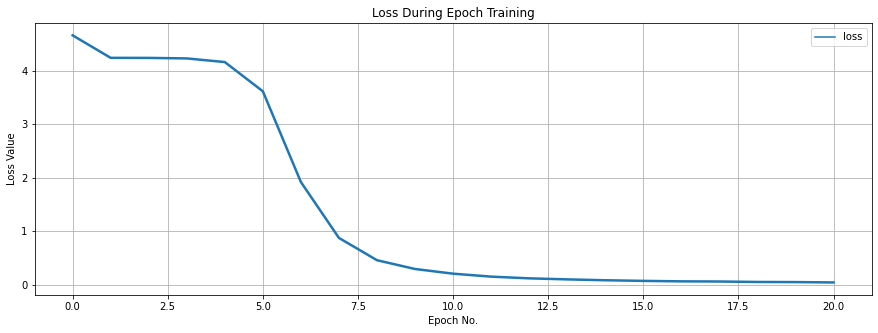

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

df_pytorch = pd.DataFrame({"loss": loss})
plt.figure(figsize=(15,5))
plt.grid()
plt.xlabel("Epoch No.")
plt.ylabel("Loss Value")
plt.title("Loss During Epoch Training")
sns.lineplot(data=df_pytorch, palette="tab10", linewidth=2.5)

## Serving Predictions

In [21]:
def get_image(image_path=None):
    if image_path == None:
        img = random.choice(df["paths"])
        return [img]
    return [image_path]


def get_sample_photo(image_path=None):
    img = get_image(image_path)
    eval_dataset = DatasetClassifier(
        image_paths=img, targets=[np.array([x for x in np.arange(10)])], resize=(IMG_HEIGHT, IMG_WIDTH)
    )

    eval_loader = torch.utils.data.DataLoader(
        eval_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        shuffle=False
    )
    return img, eval_loader


def predict_function(model, data_loader):
    model.eval()
    fin_preds = []
    with torch.no_grad(): 
        for data in data_loader:
            for k, v in data.items():
                data[k] = v.to(DEVICE)
            
            batch_preds, _ = model(**data)
            fin_preds.append(batch_preds)

    return fin_preds

In [22]:
image_path, eval_loader = get_sample_photo()
print(image_path)

def clean_decoded_predictions(unclean_predictions):
    cleaned_predictions = []
    for i in unclean_predictions:
        if i != "-":
            cleaned_predictions.append(i)
            
    cleaned_predictions = "".join(cleaned_predictions)
    
    if len(cleaned_predictions) == 10:
        return cleaned_predictions   
    
    else:
        prev = "-"
        new_cleaned_predictions = []
        for char in cleaned_predictions:
            if char == prev:
                continue
            new_cleaned_predictions.append(char)
            prev = char
        res = "".join(new_cleaned_predictions)
        return res
    
def predict_captcha(model, eval_loader, image_path):
    plt.figure(figsize=(15,5))
    image = mpimg.imread(image_path[0])
    target = image_path[0].split("/")[-1].split(".")[0]
    plt.title(image_path[0].split("/")[-1])
    plt.imshow(image)
    
    valid_preds = predict_function(model, eval_loader)
    for vp in valid_preds:
        current_preds = decode_predictions(vp, lbl_enc)
    
    preds = clean_decoded_predictions(current_preds[0])
    
    success = True if preds == target else False

    return{
        "success": success,
        "prediction": preds,
        "real": target
    }

['../input/captcha-images/qhfuoxh60a.jpg']


/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Sample Predictions

{'success': True, 'prediction': 'qhfuoxh60a', 'real': 'qhfuoxh60a'}

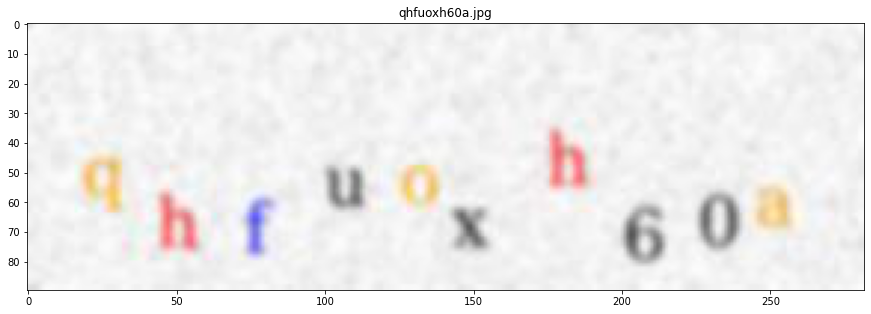

In [23]:
preds = predict_captcha(model, eval_loader, image_path)
preds